# Project 4: <br>Using Computer Vision to Detect/Determine Pneumonia Using Lung X-Ray Images 

## Business Problem

Due to a shortage of staff and doctors through COVID-19, the St.Jude Children's Hospital wants to use A.I. to diagnose pneumonia through x-ray images of children's lungs. The goal of this project is to use convolution neural network for computer vision to detect pneumonia from x-ray images. 

## Model Training

In [1]:
import tensorflow as tf
tf.random.set_seed(609)
from tensorflow.keras import callbacks, models, layers, optimizers, regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import FalsePositives

import numpy as np
np.random.seed(817)
import os

from multiprocessing import Pool

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

In [2]:
train_data_dir= 'data/train'
test_data_dir='data/test'

In [4]:
# When the batch size was reduced to 64, the results did not come out well
batch_batch=128 
target=(32,32)

In [5]:
train_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_data_dir, 
    target_size=target, 
    class_mode='binary',
    batch_size=batch_batch,
    seed=369)

test_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_set=test_generator.flow_from_directory(
    test_data_dir, 
    target_size=target,
    subset='training',
    class_mode='binary',
    batch_size=batch_batch, 
    seed=369)
val_set = test_generator.flow_from_directory(
    test_data_dir, 
    target_size=target,
    subset='validation',
    class_mode='binary',
    batch_size=batch_batch,
    seed=369)

Found 5216 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [6]:
pd.Series(train_set.labels).value_counts(1)

1    0.742906
0    0.257094
dtype: float64

In [7]:
## Get the array of weights for each unique class
weights= compute_class_weight(
           'balanced',
            np.unique(train_set.labels),
            train_set.labels)
weights

F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([1.9448173 , 0.67303226])

In [8]:
## Turn the weights into a dict with the class name as the key
weights_dict = dict(zip( np.unique(train_set.labels),weights))
weights_dict

{0: 1.9448173005219984, 1: 0.6730322580645162}

In [9]:
# Shows what classifications there are
train_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## CNN (Convolution Neural Network)

For computer vision, using the convolution neural network is recommended. For each iteration, the goal is to decrease the number of layers used while achieving a high precision for detecting pneumonia.<br>
Each iteration will have two versions: one that monitors validation loss and another that monitors validation accuracy to stop the modeling process. 


### Iteration #1

In [10]:
# Calling tf.config.run_functions_eagerly(True) will make all invocations of tf.function run eagerly 
# instead of running as a traced graph function.
tf.config.run_functions_eagerly(True)

In [11]:
base=models.Sequential()

base.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
base.add(Conv2D(128, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2)))

base.add(Conv2D(64, (3,3), activation='relu'))
base.add(Conv2D(64, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Flatten())
base.add(layers.Dense(128, activation ='relu'))
base.add(layers.Dense(64, activation ='relu'))
base.add(layers.Dense(1, activation ='sigmoid'))

base.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [12]:
# Function to show the model's loss and accuracy graph as well as the confusion matrix
def model_score(model, test_set):
    model_df=pd.DataFrame(model.history)
    
    loss_plt=model_df[[col for col in model_df.columns if 'loss' in col]].plot(marker='.')
    loss_plt.set(xlabel='Epoch',ylabel='MSE', title='Loss')
    plt.show()

    accuracy_plt=model_df[[col for col in model_df.columns if 'acc' in col]].plot(marker='.')
    accuracy_plt.set(xlabel='Epoch',ylabel='MSE', title='Accuracy')
    plt.show()
    
    test_pred = base.predict(test_set).flatten()
    test_pred=np.round(test_pred, 0)
    
    conf_matrix=metrics.confusion_matrix(test_set.labels, test_pred, normalize='true')
    sns.heatmap(conf_matrix,annot= True, cmap='Blues', linewidths=.3)
    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(metrics.classification_report(test_set.labels, test_pred))

In [13]:
# Creating callbacks for different monitors. 
stop_early_loss = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
stop_early_acc_binary = EarlyStopping(monitor='val_binary_accuracy', patience=3, verbose=1)

reduce_lr_loss=ReduceLROnPlateau(monitor= 'val_loss', patience=3, factor=.2, min_lr=.0001)
reduce_lr_acc_binary=ReduceLROnPlateau(monitor= 'val_binary_accuracy', patience=3, factor=.2, min_lr=.0001)

callback_loss=[stop_early_loss, reduce_lr_loss]
callback_acc_binary = [stop_early_acc_binary, reduce_lr_acc_binary]

In [14]:
model1_loss=base.fit(train_set, epochs=20, batch_size=batch_batch, validation_data=val_set, 
                  class_weight=weights_dict,  workers=-1, callbacks=stop_early_loss,
                  use_multiprocessing=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Epoch 1/20
41/41 [==============================] - 85s 2s/step - loss: 0.6395 - binary_accuracy: 0.6141 - val_loss: 0.3017 - val_binary_accuracy: 0.9194
Epoch 2/20
41/41 [==============================] - 58s 1s/step - loss: 0.3659 - binary_accuracy: 0.8221 - val_loss: 0.1513 - val_binary_accuracy: 0.9597
Epoch 3/20
41/41 [==============================] - 58s 1s/step - loss: 0.2325 - binary_accuracy: 0.8972 - val_loss: 0.5052 - val_binary_accuracy: 0.7419
Epoch 4/20
41/41 [==============================] - 58s 1s/step - loss: 0.1945 - binary_accuracy: 0.9212 - val_loss: 0.4983 - val_binary_accuracy: 0.7742
Epoch 5/20
41/41 [==============================] - 58s 1s/step - loss: 0.1517 - binary_accuracy: 0.9362 - val_loss: 0.5440 - val_binary_accuracy: 0.7500
Epoch 00005: early stopping


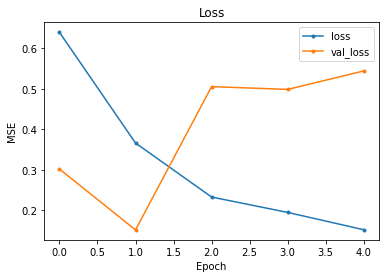

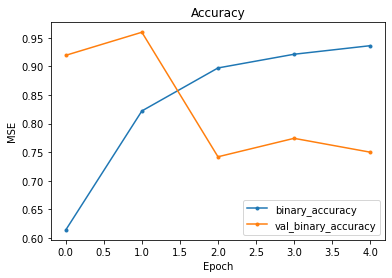

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


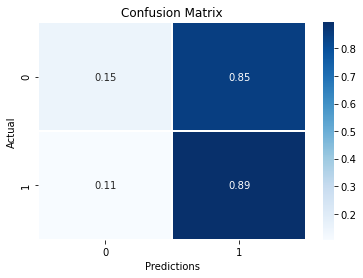

              precision    recall  f1-score   support

           0       0.46      0.15      0.22       188
           1       0.64      0.89      0.74       312

    accuracy                           0.61       500
   macro avg       0.55      0.52      0.48       500
weighted avg       0.57      0.61      0.55       500



In [15]:
model_score(model1_loss, test_set) #stop_early_acc adam

In [16]:
base=models.Sequential()

base.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
base.add(Conv2D(128, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2)))

base.add(Conv2D(64, (3,3), activation='relu'))
base.add(Conv2D(64, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Flatten())
base.add(layers.Dense(128, activation ='relu'))
base.add(layers.Dense(64, activation ='relu'))
base.add(layers.Dense(1, activation ='sigmoid'))

base.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [17]:
model1_acc=base.fit(train_set, epochs=20, batch_size=batch_batch, validation_data=val_set, 
                  class_weight=weights_dict,  workers=-1, callbacks=stop_early_acc_binary,
                  use_multiprocessing=True)

Epoch 1/20
41/41 [==============================] - 59s 1s/step - loss: 0.6935 - binary_accuracy: 0.7015 - val_loss: 0.6936 - val_binary_accuracy: 0.3710
Epoch 2/20
41/41 [==============================] - 58s 1s/step - loss: 0.5823 - binary_accuracy: 0.6030 - val_loss: 0.3374 - val_binary_accuracy: 0.8306
Epoch 3/20
41/41 [==============================] - 58s 1s/step - loss: 0.3485 - binary_accuracy: 0.8491 - val_loss: 0.3614 - val_binary_accuracy: 0.8145
Epoch 4/20
41/41 [==============================] - 58s 1s/step - loss: 0.2260 - binary_accuracy: 0.9133 - val_loss: 0.2209 - val_binary_accuracy: 0.9194
Epoch 5/20
41/41 [==============================] - 58s 1s/step - loss: 0.1881 - binary_accuracy: 0.9174 - val_loss: 0.2471 - val_binary_accuracy: 0.8790
Epoch 6/20
41/41 [==============================] - 58s 1s/step - loss: 0.1556 - binary_accuracy: 0.9390 - val_loss: 0.2561 - val_binary_accuracy: 0.8710
Epoch 7/20
41/41 [==============================] - 58s 1s/step - loss: 0.16

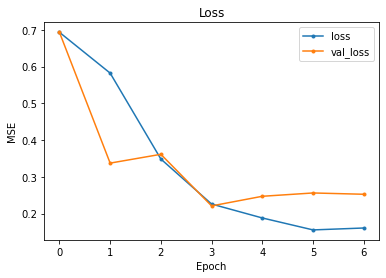

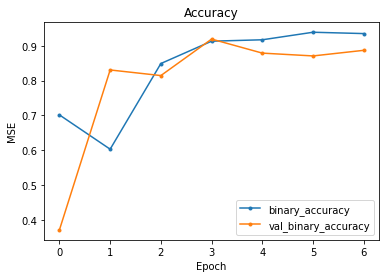

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


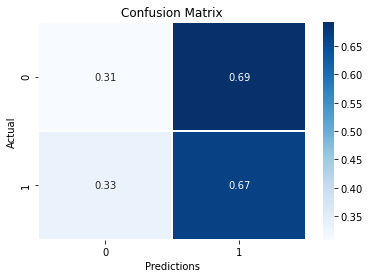

              precision    recall  f1-score   support

           0       0.36      0.31      0.33       188
           1       0.62      0.67      0.64       312

    accuracy                           0.53       500
   macro avg       0.49      0.49      0.49       500
weighted avg       0.52      0.53      0.52       500



In [18]:
model_score(model1_acc, test_set) #stop_early_loss AdaMax

While recall rate seems to be doing decent when predicting pneumonia in patients, it mostly predicts everyone to have pneumonia. 

### Iteration #2


In [19]:
iter_2=models.Sequential()

iter_2.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter_2.add(Conv2D(128, (3,3), activation='relu'))
iter_2.add(MaxPooling2D((2, 2)))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Flatten())
iter_2.add(layers.Dense(128, activation ='relu'))
iter_2.add(layers.Dense(64, activation ='relu'))
iter_2.add(layers.Dense(1, activation ='sigmoid'))

iter_2.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [20]:
iter_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 7, 7, 64)         

In [21]:
model2_loss=iter_2.fit(train_set, epochs=20, batch_size=batch_batch, validation_data=val_set, 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_loss,
                  use_multiprocessing=True)

Epoch 1/20
41/41 [==============================] - 60s 1s/step - loss: 0.6873 - binary_accuracy: 0.5360 - val_loss: 0.4470 - val_binary_accuracy: 0.9516
Epoch 2/20
41/41 [==============================] - 58s 1s/step - loss: 0.4030 - binary_accuracy: 0.8219 - val_loss: 0.0984 - val_binary_accuracy: 0.9839
Epoch 3/20
41/41 [==============================] - 59s 1s/step - loss: 0.1902 - binary_accuracy: 0.9185 - val_loss: 0.2208 - val_binary_accuracy: 0.8871
Epoch 4/20
41/41 [==============================] - 60s 1s/step - loss: 0.1440 - binary_accuracy: 0.9410 - val_loss: 0.3029 - val_binary_accuracy: 0.8468
Epoch 5/20
41/41 [==============================] - 59s 1s/step - loss: 0.1344 - binary_accuracy: 0.9444 - val_loss: 0.6149 - val_binary_accuracy: 0.7742
Epoch 00005: early stopping


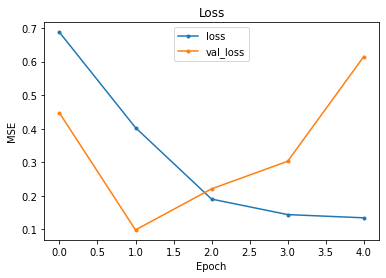

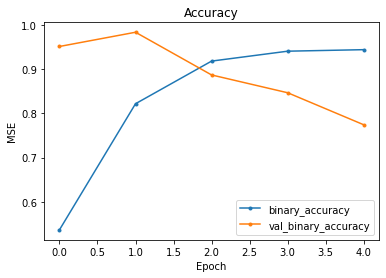

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


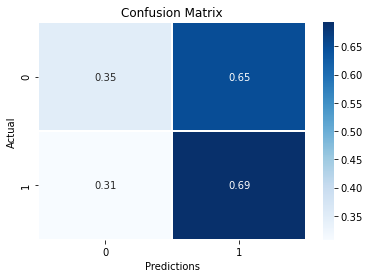

              precision    recall  f1-score   support

           0       0.41      0.35      0.38       188
           1       0.64      0.69      0.66       312

    accuracy                           0.56       500
   macro avg       0.52      0.52      0.52       500
weighted avg       0.55      0.56      0.56       500



In [22]:
model_score(model2_loss, test_set)

In [23]:
iter_2=models.Sequential()

iter_2.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter_2.add(Conv2D(128, (3,3), activation='relu'))
iter_2.add(MaxPooling2D((2, 2)))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Flatten())
iter_2.add(layers.Dense(128, activation ='relu'))
iter_2.add(layers.Dense(64, activation ='relu'))
iter_2.add(layers.Dense(1, activation ='sigmoid'))

iter_2.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [24]:
model2_acc=iter_2.fit(train_set, epochs=20, batch_size=batch_batch, validation_data=val_set, 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_acc_binary,
                  use_multiprocessing=True)

Epoch 1/20
41/41 [==============================] - 60s 1s/step - loss: 0.6104 - binary_accuracy: 0.5968 - val_loss: 0.1832 - val_binary_accuracy: 0.9355
Epoch 2/20
41/41 [==============================] - 58s 1s/step - loss: 0.3104 - binary_accuracy: 0.8629 - val_loss: 0.3735 - val_binary_accuracy: 0.7984
Epoch 3/20
41/41 [==============================] - 59s 1s/step - loss: 0.1886 - binary_accuracy: 0.9210 - val_loss: 0.2409 - val_binary_accuracy: 0.8710
Epoch 4/20
41/41 [==============================] - 59s 1s/step - loss: 0.1419 - binary_accuracy: 0.9433 - val_loss: 0.4362 - val_binary_accuracy: 0.8306
Epoch 00004: early stopping


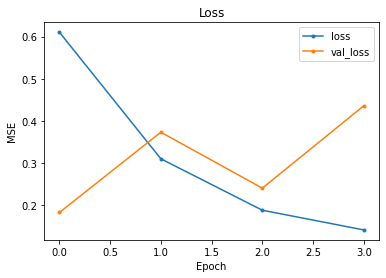

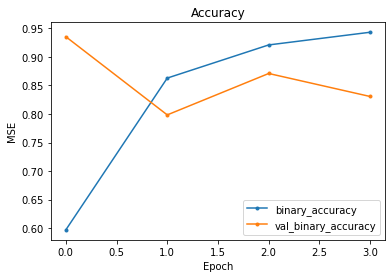

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


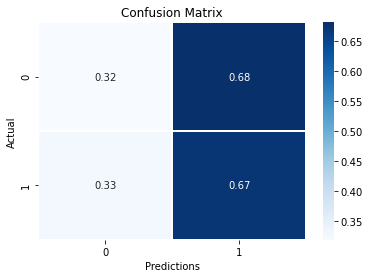

              precision    recall  f1-score   support

           0       0.37      0.32      0.34       188
           1       0.62      0.67      0.65       312

    accuracy                           0.54       500
   macro avg       0.50      0.50      0.49       500
weighted avg       0.53      0.54      0.53       500



In [25]:
model_score(model2_acc, test_set)

### Iteration #3

In [26]:
iter3=models.Sequential()

iter3.add(Conv2D(64, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Flatten())
iter3.add(layers.Dense(64, activation ='relu'))
iter3.add(layers.Dense(1, activation ='sigmoid'))

iter3.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [27]:
iter3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 13, 13, 32)        18464     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 3, 3, 32)          9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 1, 1, 32)         

In [28]:
model3_loss=iter3.fit(train_set, epochs=20, batch_size=batch_batch,
               validation_data=val_set, class_weight=weights_dict,  workers=-1, callbacks=callback_loss,
               use_multiprocessing=True)

Epoch 1/20
41/41 [==============================] - 53s 1s/step - loss: 0.6126 - binary_accuracy: 0.6607 - val_loss: 0.4701 - val_binary_accuracy: 0.7742
Epoch 2/20
41/41 [==============================] - 52s 1s/step - loss: 0.3358 - binary_accuracy: 0.8480 - val_loss: 0.2091 - val_binary_accuracy: 0.9194
Epoch 3/20
41/41 [==============================] - 51s 1s/step - loss: 0.2759 - binary_accuracy: 0.8811 - val_loss: 0.2409 - val_binary_accuracy: 0.8871
Epoch 4/20
41/41 [==============================] - 51s 1s/step - loss: 0.2207 - binary_accuracy: 0.9066 - val_loss: 0.2260 - val_binary_accuracy: 0.8790
Epoch 5/20
41/41 [==============================] - 51s 1s/step - loss: 0.1985 - binary_accuracy: 0.9187 - val_loss: 0.1995 - val_binary_accuracy: 0.9194
Epoch 6/20
41/41 [==============================] - 51s 1s/step - loss: 0.1762 - binary_accuracy: 0.9312 - val_loss: 0.1886 - val_binary_accuracy: 0.9274
Epoch 7/20
41/41 [==============================] - 51s 1s/step - loss: 0.19

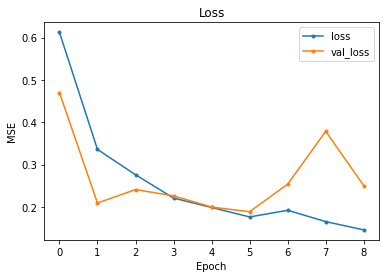

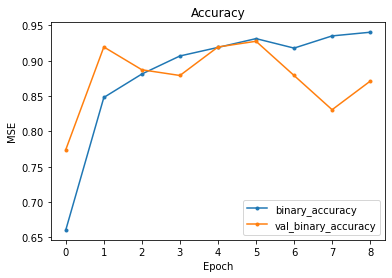

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


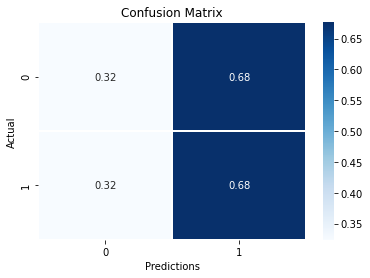

              precision    recall  f1-score   support

           0       0.38      0.32      0.35       188
           1       0.62      0.68      0.65       312

    accuracy                           0.54       500
   macro avg       0.50      0.50      0.50       500
weighted avg       0.53      0.54      0.54       500



In [29]:
model_score(model3_loss, test_set) 

In [30]:
iter3=models.Sequential()

iter3.add(Conv2D(64, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Flatten())
iter3.add(layers.Dense(64, activation ='relu'))
iter3.add(layers.Dense(1, activation ='sigmoid'))

iter3.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [31]:
model3_acc=iter3.fit(train_set, epochs=20, batch_size=batch_batch, 
               validation_data=val_set, class_weight=weights_dict,  workers=-1, callbacks=callback_acc_binary,
               use_multiprocessing=True)

Epoch 1/20
41/41 [==============================] - 53s 1s/step - loss: 0.6253 - binary_accuracy: 0.5353 - val_loss: 0.3542 - val_binary_accuracy: 0.8952
Epoch 2/20
41/41 [==============================] - 51s 1s/step - loss: 0.3656 - binary_accuracy: 0.8374 - val_loss: 0.2188 - val_binary_accuracy: 0.9194
Epoch 3/20
41/41 [==============================] - 51s 1s/step - loss: 0.3664 - binary_accuracy: 0.8338 - val_loss: 0.2722 - val_binary_accuracy: 0.9032
Epoch 4/20
41/41 [==============================] - 54s 1s/step - loss: 0.3139 - binary_accuracy: 0.8572 - val_loss: 0.2032 - val_binary_accuracy: 0.9274
Epoch 5/20
41/41 [==============================] - 56s 1s/step - loss: 0.2626 - binary_accuracy: 0.8909 - val_loss: 0.1936 - val_binary_accuracy: 0.9355
Epoch 6/20
41/41 [==============================] - 54s 1s/step - loss: 0.2238 - binary_accuracy: 0.9068 - val_loss: 0.3186 - val_binary_accuracy: 0.8145
Epoch 7/20
41/41 [==============================] - 55s 1s/step - loss: 0.18

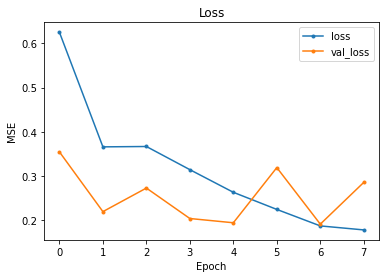

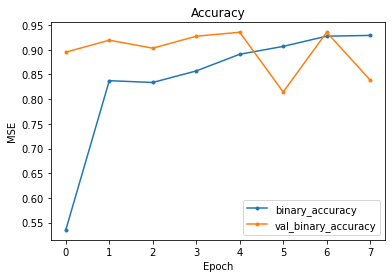

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


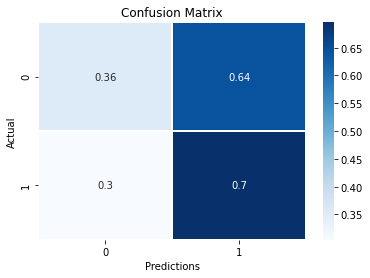

              precision    recall  f1-score   support

           0       0.41      0.36      0.38       188
           1       0.64      0.70      0.67       312

    accuracy                           0.57       500
   macro avg       0.53      0.53      0.53       500
weighted avg       0.56      0.57      0.56       500



In [32]:
model_score(model3_acc, test_set)

### Iteration #4

Removed much of the layers and maxpooling2d, changed metrics to binary accuracy 

In [34]:
iter4=models.Sequential()

iter4.add(Conv2D(64, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Conv2D(32, (3,3), activation='relu'))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Flatten())
iter4.add(layers.Dense(64, activation ='relu'))
iter4.add(layers.Dense(1, activation ='sigmoid'))

iter4.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [42]:
model4_loss=iter4.fit(train_set, epochs=20, batch_size=batch_batch,
               validation_data=val_set, class_weight=weights_dict,  workers=-1, callbacks=callback_loss,
               use_multiprocessing=True)

Epoch 1/20
41/41 [==============================] - 53s 1s/step - loss: 0.5451 - binary_accuracy: 0.6839 - val_loss: 0.3024 - val_binary_accuracy: 0.8952
Epoch 2/20
41/41 [==============================] - 52s 1s/step - loss: 0.2974 - binary_accuracy: 0.8685 - val_loss: 0.2247 - val_binary_accuracy: 0.9355
Epoch 3/20
41/41 [==============================] - 51s 1s/step - loss: 0.1817 - binary_accuracy: 0.9264 - val_loss: 0.2334 - val_binary_accuracy: 0.9194
Epoch 4/20
41/41 [==============================] - 51s 1s/step - loss: 0.1432 - binary_accuracy: 0.9419 - val_loss: 0.3936 - val_binary_accuracy: 0.8145
Epoch 5/20
41/41 [==============================] - 52s 1s/step - loss: 0.1223 - binary_accuracy: 0.9482 - val_loss: 0.3140 - val_binary_accuracy: 0.8710
Epoch 00005: early stopping


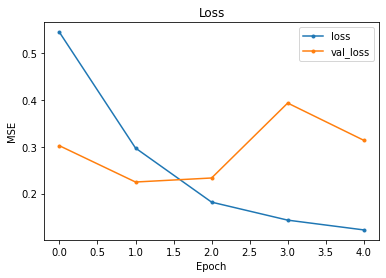

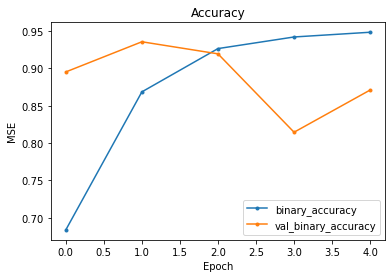

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


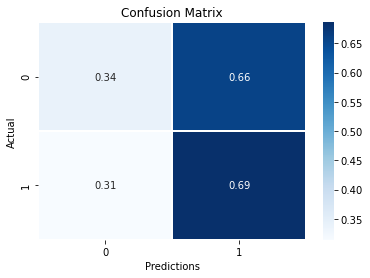

              precision    recall  f1-score   support

           0       0.40      0.34      0.37       188
           1       0.63      0.69      0.66       312

    accuracy                           0.56       500
   macro avg       0.51      0.51      0.51       500
weighted avg       0.54      0.56      0.55       500



In [43]:
model_score(model4_loss, test_set)

In [41]:
iter4=models.Sequential()

iter4.add(Conv2D(64, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Conv2D(32, (3,3), activation='relu'))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Flatten())
iter4.add(layers.Dense(64, activation ='relu'))
iter4.add(layers.Dense(1, activation ='sigmoid'))

iter4.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [38]:
model4_acc=iter4.fit(train_set, epochs=20, batch_size=batch_batch,
               validation_data=val_set, class_weight=weights_dict,  workers=-1, callbacks=callback_acc_binary,
               use_multiprocessing=True)

Epoch 1/20
41/41 [==============================] - 57s 1s/step - loss: 0.4632 - binary_accuracy: 0.7910 - val_loss: 0.2250 - val_binary_accuracy: 0.9194
Epoch 2/20
41/41 [==============================] - 57s 1s/step - loss: 0.2188 - binary_accuracy: 0.9120 - val_loss: 0.2487 - val_binary_accuracy: 0.8790
Epoch 3/20
41/41 [==============================] - 56s 1s/step - loss: 0.1588 - binary_accuracy: 0.9356 - val_loss: 0.3244 - val_binary_accuracy: 0.8387
Epoch 4/20
41/41 [==============================] - 56s 1s/step - loss: 0.1436 - binary_accuracy: 0.9415 - val_loss: 0.5934 - val_binary_accuracy: 0.7661
Epoch 00004: early stopping


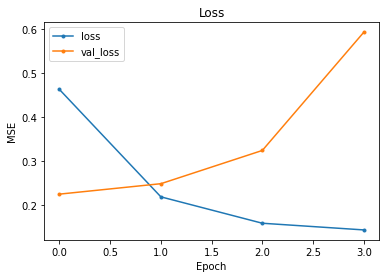

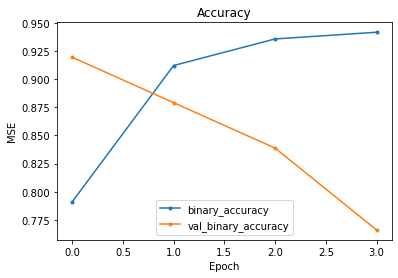

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


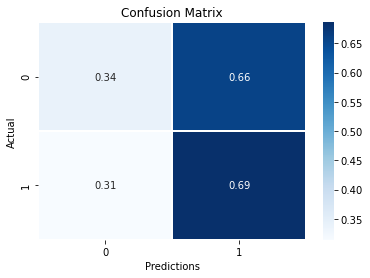

              precision    recall  f1-score   support

           0       0.40      0.34      0.37       188
           1       0.63      0.69      0.66       312

    accuracy                           0.56       500
   macro avg       0.51      0.51      0.51       500
weighted avg       0.54      0.56      0.55       500



In [39]:
model_score(model4_acc, test_set)#using top one

## Conclusion

### Model Recommendation

For each iteration of the models, there were two versions; one that looked at the validation accuracy and one that looked at validation accuracy as the main determinant in setting the stopping point for the neural network.<br>
I would recommend using the model from the 3rd iteration that uses validation accuracy  as the stopping metric. For all of the iterations, the recall rate for the true positives were similar;however, when comparing the histograms showing the training and validation scores for each epochs had the best shape, meaning that the neural network was able to learn the best from this model.


### Future Work
For future work, I would like to improve the model's prediction on false positives. While it was very apt in diagnosing pneumonia for patients with pneumonia, it was as much likely to diagnose pneumonia to those who did not have the disease. Possible solutions may be:
 - Format/align the pictures to show just the thorax region to remove possible mis-detections
 - Distinguish sections such as the heart to remove possible mis-detections
 - Separate images of bacterial pneumonia and viral pneumonia for training for ease of diagnosis since they require different treatments. 
 
### Final Thoughts
Overall, the project was as challenging as it was insightful. After visiting an A.I. expo and seeing how computer vision was being used to diagnose cancer and how the A.I. that they had created were finding previously unknown indications that could lead to an early diagnosis of breast cancer. The year before this, the doctors had found a tumor-like tissue in her uterus during an annual check up. Fortunately it turned out to be a benign form, but we were worried that she could develop breast cancer as uterine tumors could lead to or were early signs of breast cancer. Because of this previous incident, the use of A.I. in diagnosing cancer spoke to me in a different way, and I became much interested in general A.I. and the use of A.I. in the medical field. Though this project is miles behind compared to what I had seen in the expo, it was meaningful nonetheless.